 # Problema 3 "¿Sabes qué comes?" (Grupal)
David Morais  
Eudald Pizarro  
Marc Teixidó  
Joan Montobbio

Comer adecuadamente es importante para mantener la salud. Vamos a utilizar un conjunto de datos que describe los nutrientes de distintos alimentos y platos. Este conjunto contiene ocho grupos de alimentos clasificados según sus nutrientes. Exploraremos diferentes clasificadores lineales para encontrar un modelo capaz de predecir el grupo al que pertenece cada alimento.  
Los datos pueden obtenerse mediante la librería ``apafib`` mediante la función ``load_food``.

In [1]:
#!pip install apafib --upgrade --quiet
#!pip install ucimlrepo --upgrade --quiet
#!pip install -U numpy scipy scikit-learn pandas matplotlib seaborn statsmodels yellowbrick

In [2]:
import pandas as pd
from apafib import load_food

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import set_config
from sklearn.metrics import  ConfusionMatrixDisplay,classification_report,accuracy_score, f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from yellowbrick.target.feature_correlation import feature_correlation
from yellowbrick.classifier.rocauc import roc_auc

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

import warnings

set_config(display='text')
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16})
pd.set_option('display.precision', 3)

In [3]:
def save_results(clf, X_test, y_test, nclf, df):
    if hasattr(clf, 'best_score_'):
        df.loc[nclf,'train XV acc'] = clf.best_score_
    else:
        df.loc[nclf,'train XV acc'] = np.nan
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (M)'] = precision_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'recall score (M)'] = recall_score(y_test, clf.predict(X_test), average='macro')
    df.loc[nclf,'f1 score (M)'] = f1_score(y_test, clf.predict(X_test), average='macro')
    return df

results_df = pd.DataFrame()

niter = 15
cv = 5

## Apartat a)
 - Dividir conjunt en 70%/30% (amb estratificació).
 - Normalitzar les dades i fer una visualització mínima.
 - Aplicar PCA i t-SNE i comentar separabilitat.

In [4]:
data = load_food()
X= data.iloc[:,:-1]
y= data.loc[:,'Class'].copy()

In [5]:
X.head()
X.describe(include='all').T

,Caloric Value,Fat,Saturated Fats,Monounsaturated Fats,Polyunsaturated Fats,Carbohydrates,Sugars,Protein,Dietary Fiber,Cholesterol,...,Calcium,Copper,Iron,Magnesium,Manganese,Phosphorus,Potassium,Selenium,Zinc,Nutrition Density
food,,,,,,,,,,,,,,,,,,,,,
cream cheese,51,5.0,2.9,1.3,0.200,0.8,0.500,0.9,0.0,14.6,...,0.008,14.100,0.082,0.027,1.300,0.091,15.5,19.100,0.039,7.070
neufchatel cheese,215,19.4,10.9,4.9,0.800,3.1,2.700,7.8,0.0,62.9,...,99.500,0.034,0.100,8.500,0.088,117.300,129.2,0.054,0.700,130.100
requeijao cremoso light catupiry,49,3.6,2.3,0.9,0.000,0.9,3.400,0.8,0.1,0.0,...,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,5.400
ricotta cheese,30,2.0,1.3,0.5,0.002,1.5,0.091,1.5,0.0,9.8,...,0.097,41.200,0.097,0.096,4.000,0.024,30.8,43.800,0.035,5.196
cream cheese low fat,30,2.3,1.4,0.6,0.042,1.2,0.900,1.2,0.0,8.1,...,22.200,0.072,0.008,1.200,0.098,22.800,37.1,0.034,0.053,27.007


,count,mean,std,min,25%,50%,75%,max
Caloric Value,1622.0,247.187,366.885,0.0,61.000,148.000,3.185e+02,6077.000
Fat,1622.0,11.074,28.313,0.0,0.400,3.100,1.128e+01,550.700
Saturated Fats,1622.0,3.856,10.276,0.0,0.078,0.800,3.600e+00,167.600
Monounsaturated Fats,1622.0,4.648,13.378,0.0,0.078,0.900,4.200e+00,291.100
Polyunsaturated Fats,1622.0,2.034,5.174,0.0,0.082,0.500,1.900e+00,64.400
Carbohydrates,1622.0,19.435,29.577,0.0,0.100,6.000,2.900e+01,225.800
Sugars,1622.0,4.695,11.472,0.0,0.000,0.000,3.400e+00,97.700
Protein,1622.0,16.497,32.264,0.0,1.200,5.550,1.955e+01,560.300
Dietary Fiber,1622.0,2.208,5.580,0.0,0.000,0.000,1.900e+00,58.600
Cholesterol,1622.0,62.433,162.530,0.0,0.000,2.500,5.950e+01,1936.700


In [6]:
y.head()

print("\nGrups de menjar:", np.sort(y.unique()))


food
cream cheese                        0
neufchatel cheese                   5
requeijao cremoso light catupiry    3
ricotta cheese                      0
cream cheese low fat                0
Name: Class, dtype: int64


Grups de menjar: [0 1 2 3 4 5 6 7]


In [7]:
print(f'Hi ha', X.isna().sum().sum(), 'valors nuls.')

Hi ha 0 valors nuls.


### Dividir el conjunt

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=73, stratify=y)

### Normalitzar i exploració mínima

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

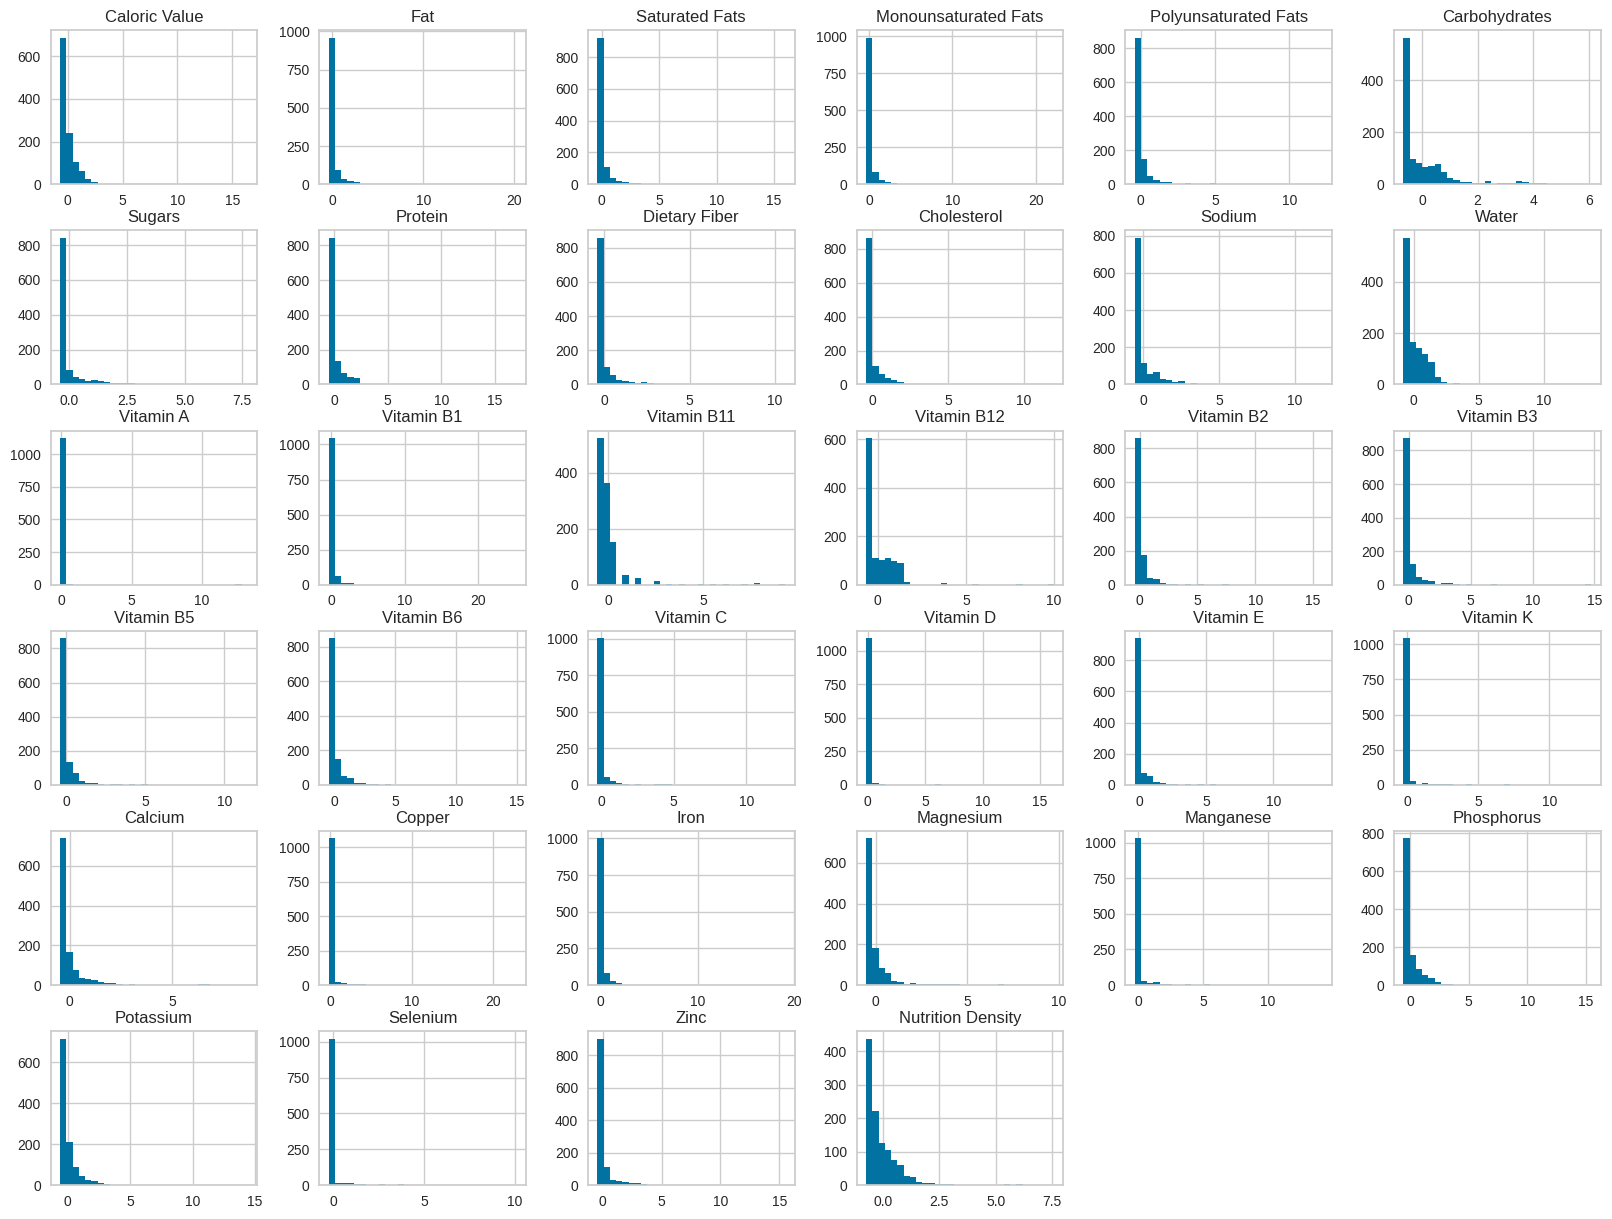

In [10]:

X_train_scaled.hist(figsize=(20,15), bins=30)
plt.show();

Podem veure que totes les variables tenen alguna cosa en comú: tots els gràfics estan desbalancejats cap a l'esquerra. És a dir, la majoria d'aliments tenen valors nutricionals relativament baixos.

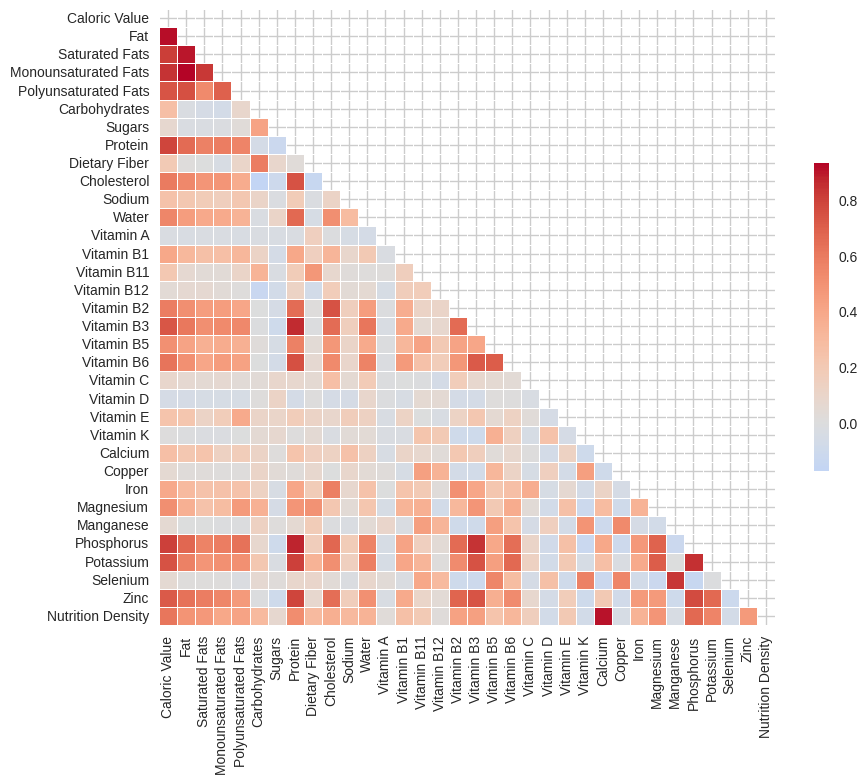

In [11]:
corr = X_train_scaled.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='coolwarm',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});
plt.show();

Podem veure que existeixen fortes dependències entre calories i greixos, o bé, entre proteïnes i alguns dels minerals. Gràcies a això podem entendre que les variables no són independents, cosa que probablement es podrà veure reflectit en models com `Naive Bayes`, ja que aquest assumeix que les variables són independents i podria tenir un rendiment inferior.

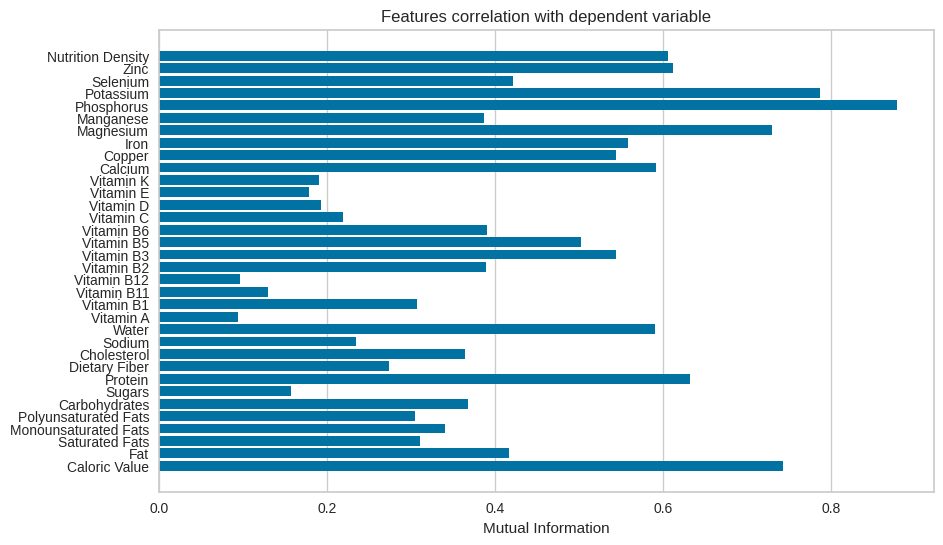

In [12]:
plt.figure(figsize=(10, 6))
visualizer = feature_correlation(X_train_scaled, y_train, labels=list(X_train_scaled.columns), method='mutual_info-classification');

Aquest gràfic ens mostra quines variables són més informatives per a la nostra variable objectiu. Podem veure que totes tenen una mica d'informació per a la classificació de grups. Però cal destacar que les que tenen, amb diferència, més correlació amb la variable objectiu són **Phosphorus**, **Potassium**, **Fat** i **Magnesium**, que són les que aporten més informació mútua per a la classificació.

### PCA i t-SNE

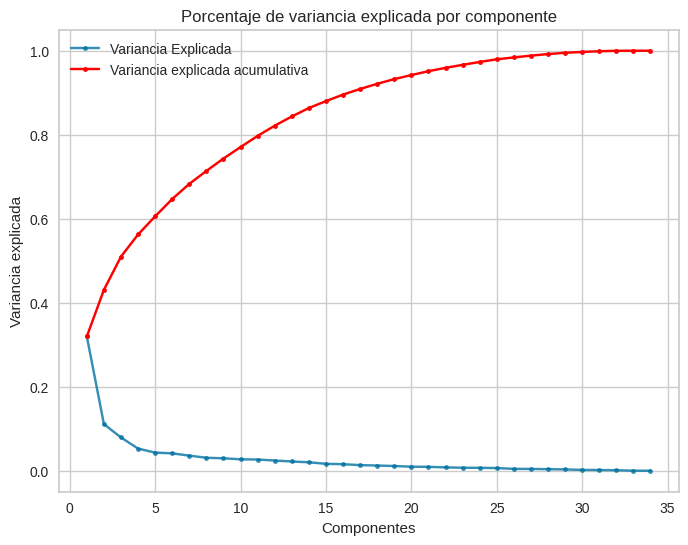

In [13]:
pca = PCA().fit(X_train_scaled)

fig = plt.figure(figsize=(8,6))
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada")
y_label = plt.ylabel('Variancia explicada')
x_label = plt.xlabel('Componentes')
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa")
plt.legend()
plt.title('Porcentaje de variancia explicada por componente');


Aquí podem veure que les dues primeres components només capturen un ~45% de la variància total, és a dir, es batant probable que amb el PCA no s'apreci una separabilitat clara. Però la situació canvia quan tenim en compte 11 component, ja que ja ens trobem amb una varianza explicativa global del 80%. Això indica per representar adequadament la complexitat de les dades necessitarem moltes dimensions.

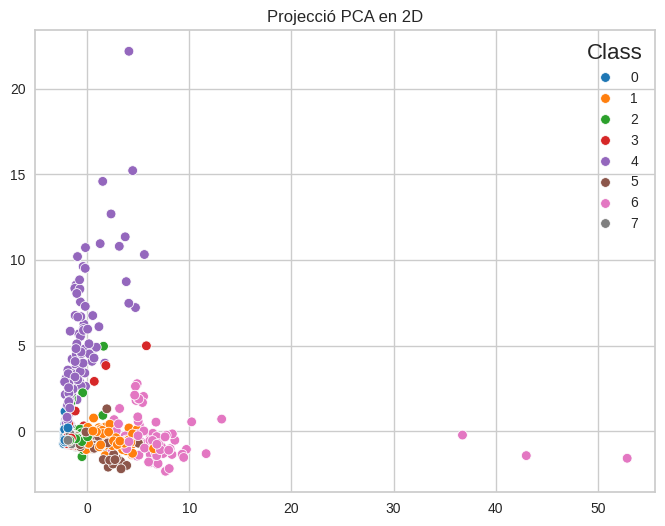

In [14]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_train, palette='tab10')
plt.title('Projecció PCA en 2D')
plt.show();

Bé, el que intuiem abans, no n'hi ha una separabilitat clara entre els grups, de fet n'hi ha alguns que pràcticament ni es veuen ja que queden solapats. El que més destaca seria el grup 4 i el 6. El 4 perque es troba en el costat esquerra de la grafica amb tots els punts relativament concentrats formant una columna, i del grup 6 doncs estan tots concentrat ente les x 5-10 excetpe 3 outliers. Pel que fa tots els grups, doncs es veu una concentració massiva a la zona inferior que no permet veure bé el comportament d'aquests.

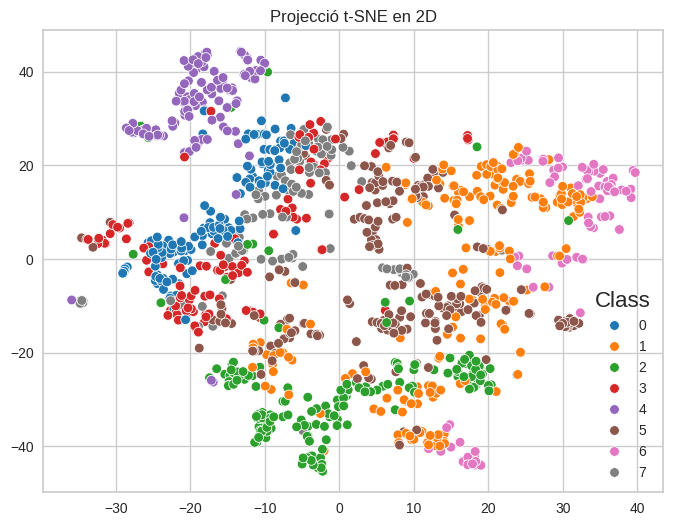

In [15]:
# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train_scaled)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y_train, palette='tab10')
plt.title('Projecció t-SNE en 2D')
plt.show();

En el `t-SNE` si que és pot veure més separabilitat entre els grups, però tampoc acaba de tenir una visió clara, ja que estan tots molt dispersos, peró de totes les maneres ja és pot observar un patró més clars, la majoria dels grup és podria dir que estan al voltant d'una diagonal, exepte el 1 i 5 que és veuen més dispersos respecte els altre. El grups que mostren major concentració, és a dir, que tenen els clusters millor definits seria el 2, abaix a l'esquerra, el 0 que es veu una diagonal clara i el 4 que és veu un clúster clar a dalt a l'esquerra.

Tot i que és cert que en el `t-SNE` i en `PCA`és poden distingir alguns patrons notables, en el `t-SNE` ens permet veure millor separabilitat, això ens fa pensar que les relacions entre les variables poden ser no lineals, i per tant, models de classificació no lineals podrien tenir un millor rendiment que models lineals simples.

## Apartat b)
 - Aplicar un Naive Bayes

In [16]:
gnb = GaussianNB()
gnb.best_score_ = np.mean(cross_val_score(gnb,X_train_scaled,y_train,cv=10))
print(gnb.best_score_)

0.7576773792889302


Jutjant per l'error de validació creuada, és podria dir que el **GNB** s'ajusta bé, ja que té un valor de 75.76%. Cosa que ens xoca una mica amb la valoració inicial que havíem fet de les dades.

In [17]:
gnb_model = GaussianNB().fit(X_train_scaled, y_train)
gnb_model.best_score_ = gnb.best_score_
print('Priors:', gnb_model.class_prior_)
print('Means:\n')
means =pd.DataFrame(gnb_model.theta_)
means.columns=X.columns
means

Priors: [0.11982379 0.18854626 0.15066079 0.10220264 0.09515419 0.1753304
 0.08105727 0.08722467]
Means:



,Caloric Value,Fat,Saturated Fats,Monounsaturated Fats,Polyunsaturated Fats,Carbohydrates,Sugars,Protein,Dietary Fiber,Cholesterol,...,Calcium,Copper,Iron,Magnesium,Manganese,Phosphorus,Potassium,Selenium,Zinc,Nutrition Density
0,-0.657,-0.403,-0.381,-0.345,-0.376,-0.599,-0.327,-0.500,-0.362,-0.384,...,-0.447,-0.143,-0.317,-0.491,-0.221,-0.546,-0.581,-0.223,-0.426,-0.693
1,0.397,0.190,0.108,0.129,0.178,0.487,0.074,0.337,0.237,0.118,...,0.120,-0.192,0.148,0.494,-0.209,0.440,0.492,-0.251,0.366,0.300
2,-0.333,-0.330,-0.322,-0.300,-0.288,0.071,0.221,-0.407,-0.045,-0.361,...,-0.261,-0.158,-0.180,-0.285,-0.199,-0.415,-0.286,-0.232,-0.298,-0.300
3,-0.431,-0.273,-0.170,-0.141,-0.181,-0.385,-0.090,-0.421,-0.355,-0.173,...,-0.415,-0.175,-0.240,-0.433,-0.221,-0.462,-0.534,-0.214,-0.380,-0.586
4,-0.078,-0.111,-0.099,-0.112,-0.158,0.084,0.143,-0.042,0.181,-0.126,...,-0.475,1.691,-0.314,-0.493,2.079,-0.563,-0.268,2.283,-0.440,-0.411
5,0.033,0.044,0.117,0.069,0.011,0.122,0.179,-0.104,-0.217,-0.006,...,0.669,-0.198,-0.069,-0.167,-0.244,-0.005,-0.247,-0.251,-0.101,0.501
6,1.787,1.473,1.273,1.220,1.361,0.328,-0.184,1.877,0.953,1.655,...,0.647,-0.171,1.567,1.993,-0.182,2.217,2.274,-0.251,1.878,1.373
7,-0.515,-0.305,-0.267,-0.271,-0.273,-0.543,-0.334,-0.336,-0.167,-0.290,...,-0.136,-0.199,-0.267,-0.373,-0.251,-0.378,-0.470,-0.251,-0.308,-0.327


A partir dels priors és pot veure que no n'hi ha una distribució uniforme entre les classes, destaquen sobre les altres la clasase 1 i 5  amb valors sobre el 17% i que les minoritaties son les classes 6 i 7 ja que no arriben ni al 9%, és a dir, s'observa desbalanç entre les classes.

In [18]:
print(classification_report(y_test, gnb_model.predict(X_test_scaled), target_names=[f'Class {i}' for i in sorted(y_train.unique())]))
results_df = save_results(gnb_model, X_test_scaled, y_test, 'GNB', results_df)

              precision    recall  f1-score   support

     Class 0       0.85      0.78      0.81        59
     Class 1       0.78      0.83      0.80        92
     Class 2       0.83      0.67      0.74        73
     Class 3       0.56      0.20      0.29        50
     Class 4       0.89      0.87      0.88        46
     Class 5       0.67      0.79      0.72        85
     Class 6       0.84      0.92      0.88        39
     Class 7       0.52      0.86      0.65        43

    accuracy                           0.74       487
   macro avg       0.74      0.74      0.72       487
weighted avg       0.75      0.74      0.73       487



El model `GNB` no s'ajusta del tot malament, ja que té un  **accuracy del 74%**, amb una mitjana de ***F1-score del 73%%**.  El problema és el rendiment entre les classes, ja que n'hi ha algunes amb F1-score alts (0,1,4,6), bona precisió i bon recall; però en canvi n'hi ha altres que no s'acaben d'ajustar bé, com ara la 3, amb un recall del 20% i un F1-score de només 29%. En canvi, la classe 7 té mala precisió, però bon recall, és a dir, detecta bastants falsos positius.

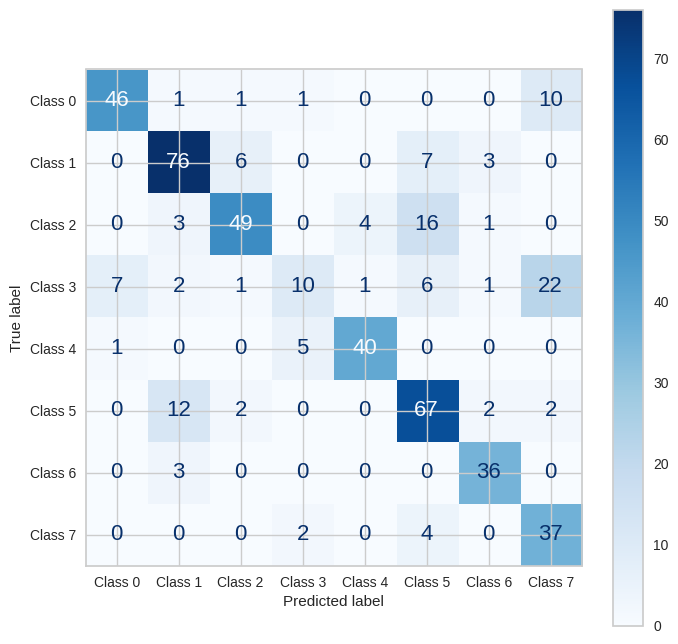

In [19]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(gnb_model, X_test_scaled, y_test, cmap="Blues",display_labels=[f'Class {i}' for i in sorted(y_train.unique())], ax=plt.subplot());

Amb la matriu de confussió podem veure millor el que representava el classification report. N'hi ha dos problemes clars, la classe 3 i la classe 7. La 3 perquè té només 10 prediccions correctes sobre 50 exemples (recall 20%), essent la majoria classificades erròniament com a classe 0. La 7, en canvi, té un problema diferent: detecta bé la majoria dels casos reals (recall 86%), però quant prediu classe 7 genera molts falsos positius. Les classes 4 i 6 són les que s'ajusten millor, amb F1-scores alts (0.88) i molt pocs falsos negatius, mostrant que són grups alimentaris clarament diferenciats.

## Apartat c)
 - Ajustar un model LDA
 - Regressió Logística amb penalització L1 i solver saga
 - Ajustar hiperparàmetres
 - Avaluar resultats

### Linear Discriminant Analysis (LDA)

In [20]:
lda = LinearDiscriminantAnalysis()
lda.best_score_ = np.mean(cross_val_score(lda, X_train_scaled, y_train, cv=10))
print('Accuracy de validació creuada LDA:', lda.best_score_)

Accuracy de validació creuada LDA: 0.6308492470113337


El `LDA` té una validació creuada de 63.08%, clarament inferior al 75.76% del `GNB`. Això confirma que el `LDA` serà un model classificador pitjor per a aquest dataset. Però la pregunta és perquè ha de ser pitjor?  
Doncs `LDA` assumeix que totes les classes comparteixen la mateixa matriu de covariància, però el més probable és que amb les nostres dades aquesta suposició no es compleixi. Reocrdant el gràfic del `t-SNE`, podem veure que els diferents grups tenen formes i dispersions diferents. I en canvi el `GNB` estima covariàncies diagonals independents per a cada clases, i permet que cada classe tingui la seva pròpia variància, el que fa que el model s'adapti millor.

In [21]:
lda_model = LinearDiscriminantAnalysis().fit(X_train_scaled, y_train)
lda_model.best_score_ = lda.best_score_

print('Priors:', lda_model.priors_)
print('\nMitjanes per classe:')
means_lda = pd.DataFrame(lda_model.means_, columns=X.columns)
means_lda.index = [f'Class {i}' for i in sorted(y_train.unique())]
means_lda

Priors: [0.11982379 0.18854626 0.15066079 0.10220264 0.09515419 0.1753304
 0.08105727 0.08722467]

Mitjanes per classe:


,Caloric Value,Fat,Saturated Fats,Monounsaturated Fats,Polyunsaturated Fats,Carbohydrates,Sugars,Protein,Dietary Fiber,Cholesterol,...,Calcium,Copper,Iron,Magnesium,Manganese,Phosphorus,Potassium,Selenium,Zinc,Nutrition Density
Class 0,-0.657,-0.403,-0.381,-0.345,-0.376,-0.599,-0.327,-0.500,-0.362,-0.384,...,-0.447,-0.143,-0.317,-0.491,-0.221,-0.546,-0.581,-0.223,-0.426,-0.693
Class 1,0.397,0.190,0.108,0.129,0.178,0.487,0.074,0.337,0.237,0.118,...,0.120,-0.192,0.148,0.494,-0.209,0.440,0.492,-0.251,0.366,0.300
Class 2,-0.333,-0.330,-0.322,-0.300,-0.288,0.071,0.221,-0.407,-0.045,-0.361,...,-0.261,-0.158,-0.180,-0.285,-0.199,-0.415,-0.286,-0.232,-0.298,-0.300
Class 3,-0.431,-0.273,-0.170,-0.141,-0.181,-0.385,-0.090,-0.421,-0.355,-0.173,...,-0.415,-0.175,-0.240,-0.433,-0.221,-0.462,-0.534,-0.214,-0.380,-0.586
Class 4,-0.078,-0.111,-0.099,-0.112,-0.158,0.084,0.143,-0.042,0.181,-0.126,...,-0.475,1.691,-0.314,-0.493,2.079,-0.563,-0.268,2.283,-0.440,-0.411
Class 5,0.033,0.044,0.117,0.069,0.011,0.122,0.179,-0.104,-0.217,-0.006,...,0.669,-0.198,-0.069,-0.167,-0.244,-0.005,-0.247,-0.251,-0.101,0.501
Class 6,1.787,1.473,1.273,1.220,1.361,0.328,-0.184,1.877,0.953,1.655,...,0.647,-0.171,1.567,1.993,-0.182,2.217,2.274,-0.251,1.878,1.373
Class 7,-0.515,-0.305,-0.267,-0.271,-0.273,-0.543,-0.334,-0.336,-0.167,-0.290,...,-0.136,-0.199,-0.267,-0.373,-0.251,-0.378,-0.470,-0.251,-0.308,-0.327


Ja haviem comentat el desbalaneig de classes en el priors del apartat del `GNB`. De la taula de mitjanes podem destacar que la classe 4 i 6 tenen valors més alts i que les calsses 0, 3 i 7 tenen valors baixos (la majoria de valors son negatius), és a dir, es veuen certs patrons clars. Aquesta heterogeneïtat en les variàncies entre classes fa que el LDA no es pugui ajustar bé, ja que intenta imposar una única estructura de covariància a totes les classes.

In [22]:
print(classification_report(y_test, lda_model.predict(X_test_scaled), target_names=[f'Class {i}' for i in sorted(y_train.unique())]))
results_df = save_results(lda_model, X_test_scaled, y_test, 'LDA', results_df)

              precision    recall  f1-score   support

     Class 0       0.38      0.93      0.54        59
     Class 1       0.84      0.70      0.76        92
     Class 2       0.80      0.92      0.85        73
     Class 3       0.53      0.32      0.40        50
     Class 4       1.00      0.70      0.82        46
     Class 5       0.63      0.61      0.62        85
     Class 6       0.97      0.79      0.87        39
     Class 7       0.50      0.07      0.12        43

    accuracy                           0.66       487
   macro avg       0.71      0.63      0.62       487
weighted avg       0.71      0.66      0.65       487



En el classification report té un **accuracy global** del 66% i un **F1-score** macro del 62%. Pel que fa a nivell individual, les classes que tenen millor rendiment (jutjant per F1-score) són la 2, 4 i 6. També es pot veure que, en general, hi ha molt desbalanceig entre el rendiment de les classes, però el problema més gros d'aquest model és la classificació de la classe 7, ja que té un **recall** horrible (7%) amb un **F1-score** molt pobre (12%). També es pot veure que la classe 0 té sobrepredicció, ja que té poca **precisió** (38%) i molt **recall** (93%).

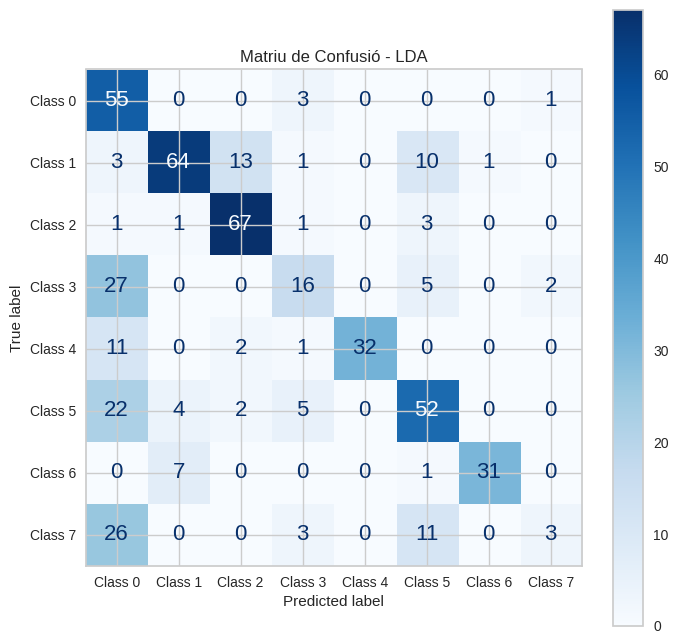

In [23]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(lda_model, X_test_scaled, y_test, cmap="Blues", display_labels=[f'Class {i}' for i in sorted(y_train.unique())], ax=plt.subplot())
plt.title('Matriu de Confusió - LDA')
plt.show();

Es pot veure la sobrepredicció de classe 0 i la subpredicció de la 7, ja que aquesta ultima practicament no s'ha predit cap bé.

Coeficients LDA:


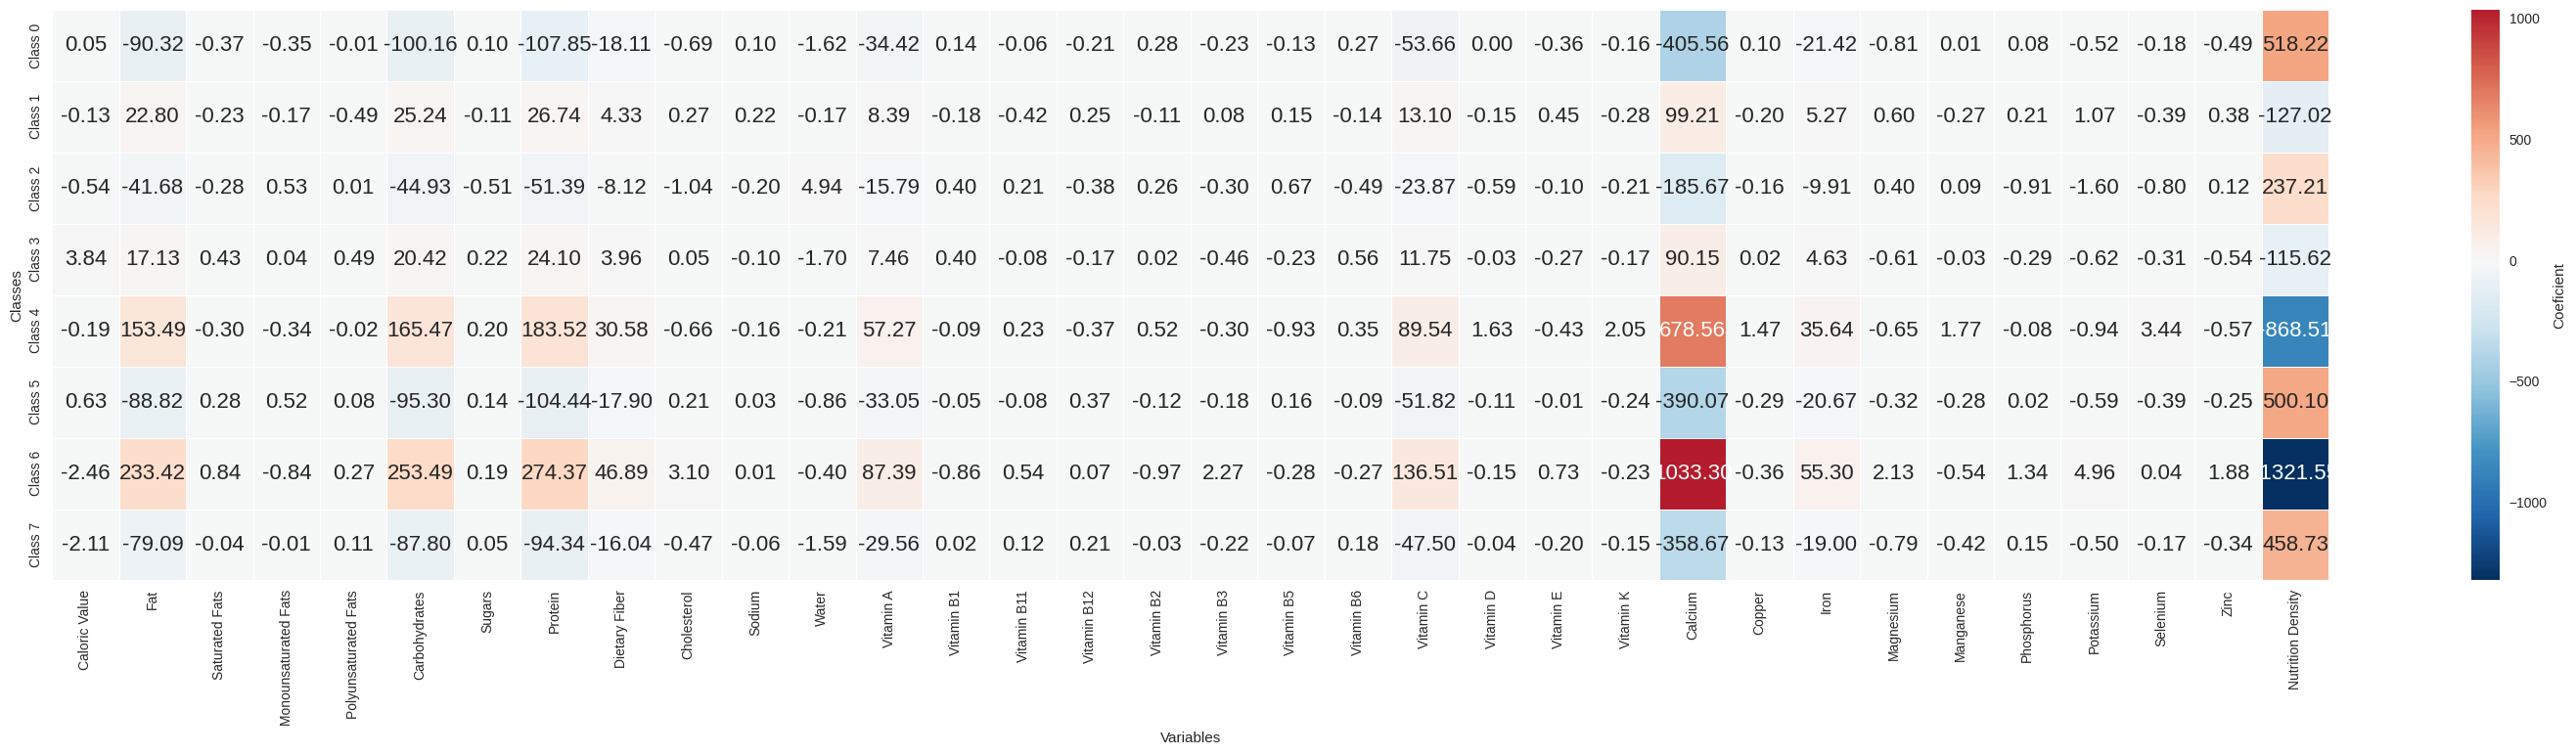

In [24]:
# Visualització dels coeficients del LDA
print('Coeficients LDA:')
coefs_lda = pd.DataFrame(lda_model.coef_, columns=X.columns)
coefs_lda.index = [f'Class {i}' for i in sorted(y_train.unique())]

plt.figure(figsize=(30,8))
sns.heatmap(coefs_lda, cmap='RdBu_r', center=0, annot=True, fmt='.2f',cbar_kws={'label': 'Coeficient'}, linewidths=0.5)
plt.xlabel('Variables')
plt.ylabel('Classes')
plt.tight_layout()
plt.show();

Els coeficients del `LDA`, ens pereten veure la importància relativa de cada variable en la construcció dels discriminants lineals. Es pot veure que les variables amb més coeficient, es a dir, amb valor absolut més alt són $Calcium$ i $Nutrition Density$, és important dir que el seu valors verien significativament en funció de les classes, ja que en algunes prenen valors postius molt alts i d'altres negatius alts. Després en menys mesura, les variable $Fat$, $Carbohydrates$, $Protein$ i $Vitamin C$ també tenen bastant pes predictiu, però amb menys mesura que les esmentades abans.

### Regressió Logística amb penalització L1 i solver SAGA

In [25]:
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100],
    'max_iter': [1000]
};

lr = LogisticRegression(penalty='l1', solver='saga', random_state=73, n_jobs=-1);
grid_lr = GridSearchCV(lr, param_grid_lr, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1);
grid_lr.fit(X_train_scaled, y_train);

print('Millors hiperparàmetres Logistic Regression:', grid_lr.best_params_)
print('Millor accuracy en validació creuada:', grid_lr.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(n_jobs=-1, penalty='l1',
                                          random_state=73, solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100],
                         'max_iter': [1000]},
             scoring='accuracy', verbose=1)

Millors hiperparàmetres Logistic Regression: {'C': 0.5, 'max_iter': 1000}
Millor accuracy en validació creuada: 0.837885462555066


In [26]:
# Resultats del GridSearch
results_lr = pd.DataFrame(grid_lr.cv_results_)
results_lr = results_lr[['param_C', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False)
results_lr.head()

,param_C,mean_test_score,std_test_score
3,0.5,0.838,0.025
5,5.0,0.837,0.024
4,1.0,0.837,0.027
8,100.0,0.836,0.024
7,50.0,0.836,0.024


In [27]:
lr_model = grid_lr.best_estimator_
print(classification_report(y_test, lr_model.predict(X_test_scaled),
                          target_names=[f'Class {i}' for i in sorted(y_train.unique())]))
results_df = save_results(grid_lr, X_test_scaled, y_test, 'LogReg L1', results_df)

              precision    recall  f1-score   support

     Class 0       0.63      1.00      0.77        59
     Class 1       0.89      0.91      0.90        92
     Class 2       0.96      0.89      0.92        73
     Class 3       0.87      0.66      0.75        50
     Class 4       0.98      0.87      0.92        46
     Class 5       0.90      0.89      0.90        85
     Class 6       0.95      0.95      0.95        39
     Class 7       0.76      0.51      0.61        43

    accuracy                           0.85       487
   macro avg       0.87      0.84      0.84       487
weighted avg       0.87      0.85      0.85       487



La `Regressió Logística` s'ajusta prou bé amb un accuracy del 85% i un **F1-score** del 84%, el qual ens diu que s'ajust bé. A nivell individual es torna a repetir que la classe amb menys rendiment es la 7 amb un f1-score del 61 i també és pot veure la mateixa tèndencia que abans de la classe 0, té sobrepredicció. Pel que fa les altres, les prediu prou bé ja que l'**f1-score** està sobre el 90% (excepte 0, 3 i 7).

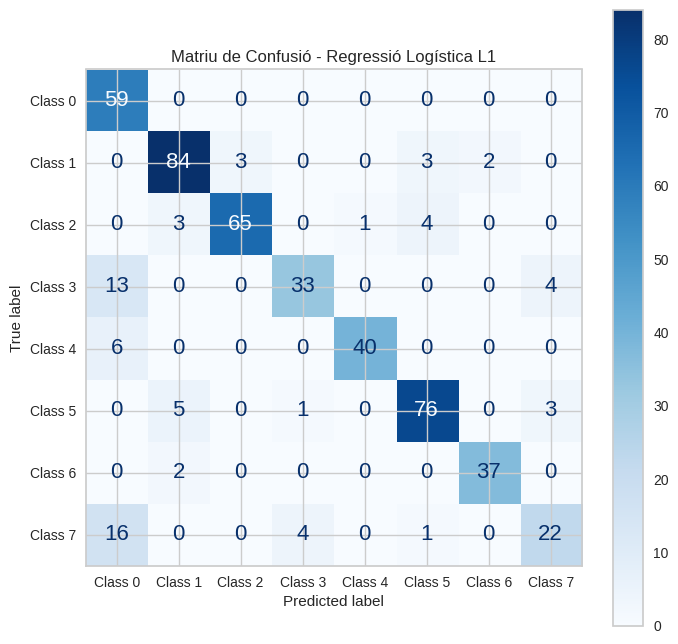

In [28]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(lr_model, X_test_scaled, y_test, cmap="Blues",
                                     display_labels=[f'Class {i}' for i in sorted(y_train.unique())],
                                     ax=plt.subplot())
plt.title('Matriu de Confusió - Regressió Logística L1')
plt.show();

Aquí la cosa comparant amb el `LDA` canvia una mica, ja que aquesta millora la classe 7 i té menys sobrepredicció sobre la classe 0. Pel que fa les altres té bon rendiment.

Nombre de coeficients no-zero: 145 de 272
Percentatge de coeficients no-zero: 53.31%


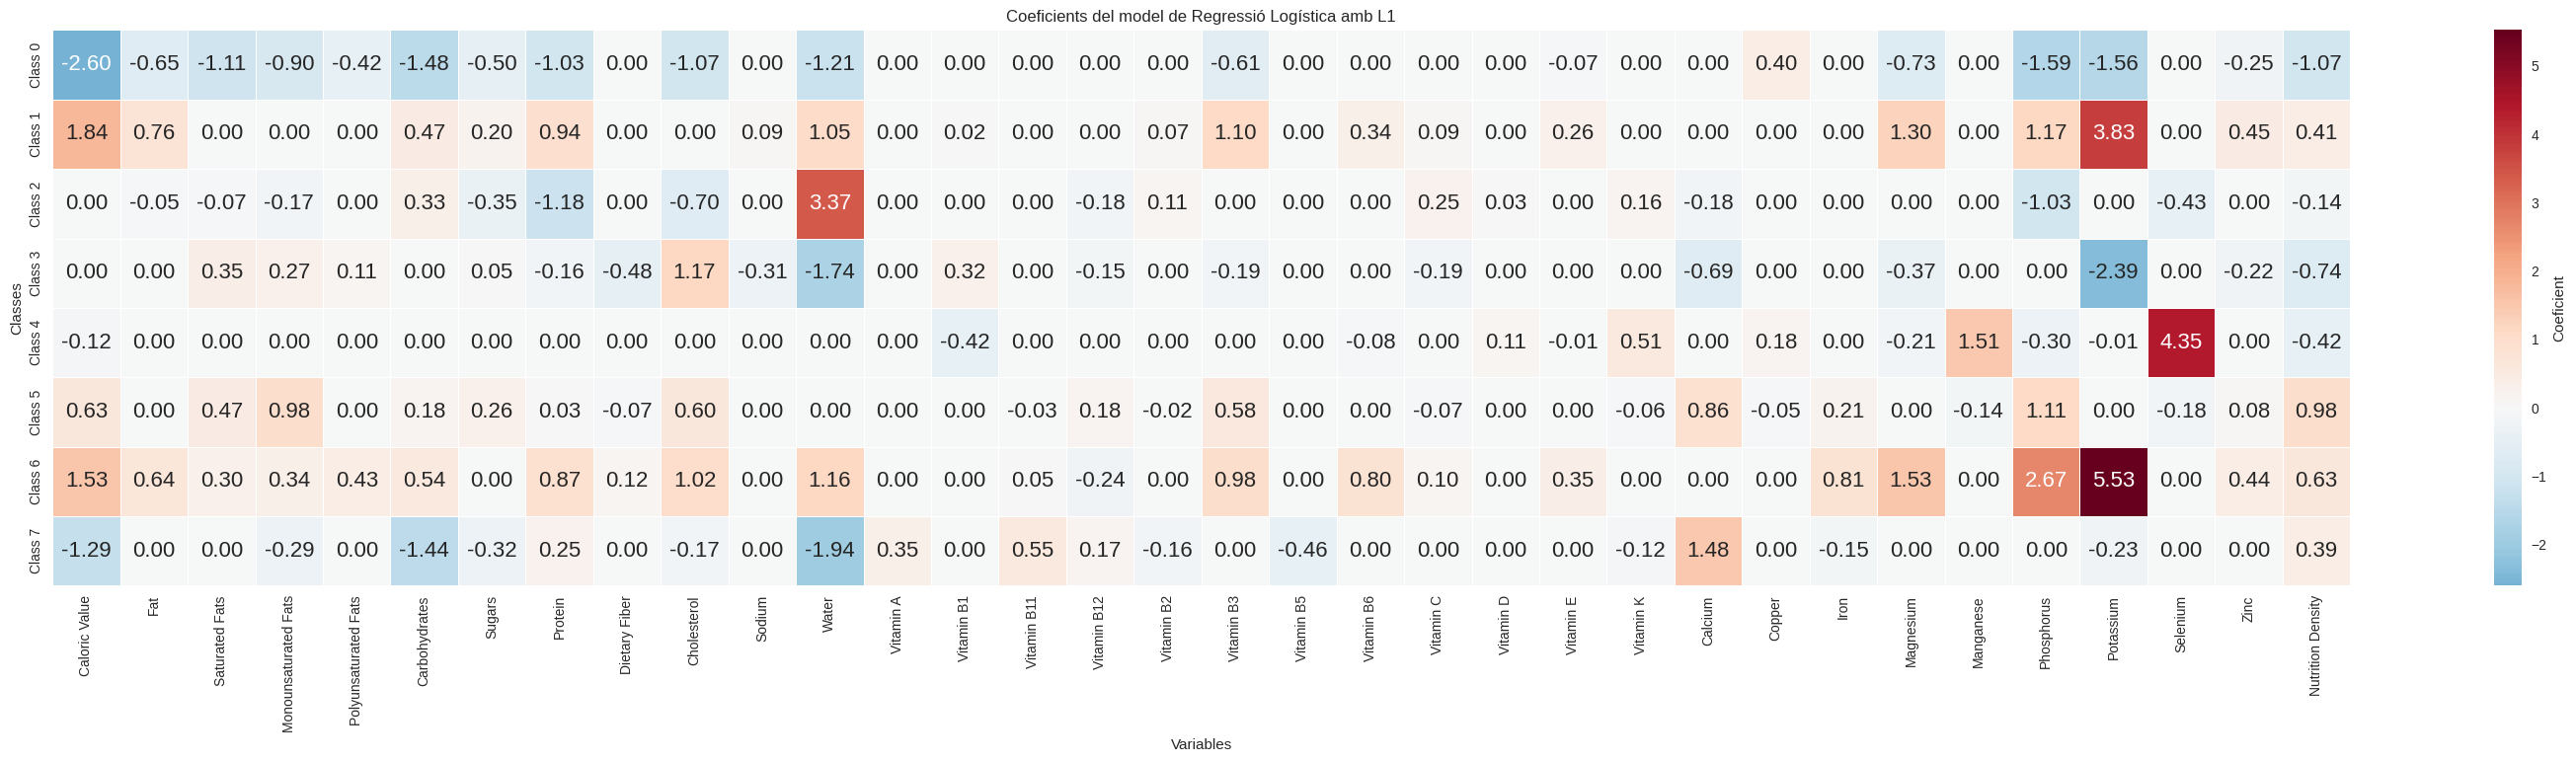

In [29]:
coefs_lr = pd.DataFrame(lr_model.coef_, columns=X.columns)
coefs_lr.index = [f'Class {i}' for i in sorted(y_train.unique())]

total_coefs = coefs_lr.shape[0] * coefs_lr.shape[1]
non_zero_coefs = np.sum((coefs_lr != 0).values)

print(f'Nombre de coeficients no-zero: {non_zero_coefs} de {total_coefs}')
print(f'Percentatge de coeficients no-zero: {100 * non_zero_coefs / total_coefs:.2f}%')

# Visualització dels coeficients
plt.figure(figsize=(30,8))
sns.heatmap(coefs_lr, cmap='RdBu_r', center=0, annot=True, fmt='.2f',
            cbar_kws={'label': 'Coeficient'}, linewidths=0.5)
plt.title('Coeficients del model de Regressió Logística amb L1')
plt.xlabel('Variables')
plt.ylabel('Classes')
plt.tight_layout()
plt.show();

És pot veure clarament que els coeficients no tenen la mateixa importancia en cada classe, és a dir, en algunes, les variables són més predictives que en altres, com per exemple $Selenium$ té bastanta importancia en la classe 4 i practicament 0 en les altres. També hi ha certs variables que no son predictives pel model ja que la majoria de pesos al llarg de les classes és 0.

De moment el model que te millors resultats pel nostre dataset és el de **Regressió Logística amb penalització L1**. Aquest model penalitza per L1, el que vol dir que força a alguns coeficients a ser 0 (que és veu clarament a la matriu dels coeficients).  
L'accuracity ha millorat una mica respecte els models anteriors, amb un aproximadament un 87%., el **F1-score** tambe és millor, que ens fa dir que el model té un rendiment més equilibrat.

### Comparació dels models

In [30]:
results_df_sorted = results_df.sort_values(by='test acc', ascending=False)
results_df_sorted

,train XV acc,test acc,precision score (M),recall score (M),f1 score (M)
LogReg L1,0.838,0.854,0.867,0.836,0.841
GNB,0.758,0.741,0.742,0.740,0.723
LDA,0.631,0.657,0.707,0.630,0.624



La **Regressió Logística amb L1** és clarament el millor classificador lineal, superant GNB en +11.3% d'accuracy i LDA en +19.7%.
Tots els models s'ajusten bé, ja que l'accuraccy entre train i test son similars.  
Ens ha estrenyat que el `LDA` vagi pitjor que el `GNB`, però podria ser perquè el nostre dataset té una estructura de covariància heterogènia, es a dir diferent segons la classe. `LDA` assumeix que totes les classes comparteixen la mateixa matriu de covariància, cosa que penalitza quan aquesta suposició no es compleix. `GNB`, en canvi, estima covariàncies diagonals independents per cada classe, cosa que aproveita millor aquesta heterogeneïtat.

## Apartat d)
- Analitzar els pesos del model de Regressió Logística amb penalització L1 (coeficients per atribut i per classe) i comentar quins atributs queden anul·lats o són poc importants.

- Aplicar l’algorisme RFECV (Recursive Feature Elimination with Cross-Validation) utilitzant com a estimador la regressió logística ajustada, per obtenir un conjunt reduït d’atributs.

- Tornar a ajustar els hiperparàmetres del model de regressió logística fent servir únicament els atributs seleccionats per RFECV.

- Avaluar el nou model (mètriques, matriu de confusió, etc.) i comparar els resultats amb els models anteriors.

- Comparar els pesos dels atributs més importants abans i després de la reducció de característiques i discutir si han canviat.

In [31]:
from sklearn.feature_selection import RFECV

base_estimator = lr_model

rfecv = RFECV(
    estimator=base_estimator,
    step=1,              # eliminar 1 variable en cada iteració
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

rfecv.fit(X_train_scaled, y_train)

print("Número òptim d' atributs:", rfecv.n_features_)

print(
    "Millor score de cross validation amb RFECV:",
    rfecv.cv_results_['mean_test_score'].max()
)

RFECV(cv=5,
      estimator=LogisticRegression(C=0.5, max_iter=1000, n_jobs=-1,
                                   penalty='l1', random_state=73,
                                   solver='saga'),
      n_jobs=-1, scoring='accuracy')

Número òptim d' atributs: 10
Millor score de cross validation amb RFECV: 0.8590308370044053


In [46]:
feature_names = np.array(X.columns)
support_mask = rfecv.support_             # True = seleccionada
ranking = rfecv.ranking_                  # 1 = seleccionada

selected_features = feature_names[support_mask]

print("Atributs seleccionats per RFECV:")
print(selected_features.tolist())


#X_train_sel = X_train_scaled[:, support_mask]
#X_test_sel  = X_test_scaled[:, support_mask]

# Si fueran DataFrames, sería:
X_train_sel = X_train_scaled.loc[:, selected_features]
X_test_sel  = X_test_scaled.loc[:, selected_features]

Atributs seleccionats per RFECV:
['Caloric Value', 'Fat', 'Carbohydrates', 'Protein', 'Cholesterol', 'Water', 'Phosphorus', 'Potassium', 'Selenium', 'Nutrition Density']


In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

lr_reduced = LogisticRegression(
    penalty='l1',
    solver='saga',
    random_state=73,
    n_jobs=-1
)

grid_lr_reduced = GridSearchCV(
    lr_reduced,
    param_grid_lr,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_lr_reduced.fit(X_train_sel, y_train)

print('Millors hiperparàmetres Logistic Regression (features reduïdes):', grid_lr_reduced.best_params_)
print('Millor accuracy en validació creuada (features reduïdes):', grid_lr_reduced.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(n_jobs=-1, penalty='l1',
                                          random_state=73, solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100],
                         'max_iter': [1000]},
             scoring='accuracy', verbose=1)

Millors hiperparàmetres Logistic Regression (features reduïdes): {'C': 5, 'max_iter': 1000}
Millor accuracy en validació creuada (features reduïdes): 0.8704845814977974



CLASSIFICATION REPORT amb features reduïdes:
              precision    recall  f1-score   support

     Class 0       0.74      0.95      0.83        59
     Class 1       0.92      0.90      0.91        92
     Class 2       0.91      0.95      0.93        73
     Class 3       0.79      0.74      0.76        50
     Class 4       0.95      0.89      0.92        46
     Class 5       0.95      0.88      0.91        85
     Class 6       0.97      0.97      0.97        39
     Class 7       0.81      0.70      0.75        43

    accuracy                           0.88       487
   macro avg       0.88      0.87      0.87       487
weighted avg       0.89      0.88      0.88       487



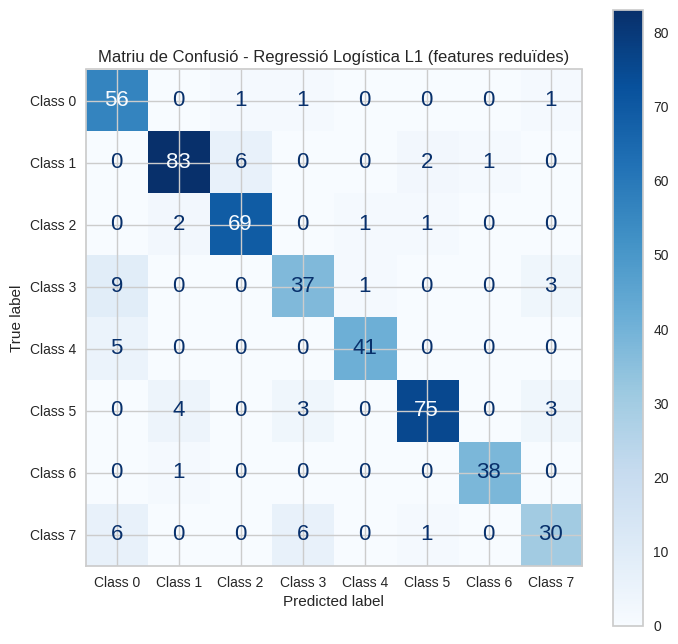

In [48]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

lr_model_reduced = grid_lr_reduced.best_estimator_

print("\nCLASSIFICATION REPORT amb features reduïdes:")
print(classification_report(
    y_test,
    lr_model_reduced.predict(X_test_sel),
    target_names=[f'Class {i}' for i in sorted(y_train.unique())]
))


results_df = save_results(grid_lr_reduced, X_test_sel, y_test, 'LogReg L1 (RFECV)', results_df)

plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(
    lr_model_reduced,
    X_test_sel,
    y_test,
    cmap="Blues",
    display_labels=[f'Class {i}' for i in sorted(y_train.unique())],
    ax=plt.subplot()
)
plt.title('Matriu de Confusió - Regressió Logística L1 (features reduïdes)')
plt.show();


Coeficients del model amb features reduïdes:


,Caloric Value,Fat,Carbohydrates,Protein,Cholesterol,Water,Phosphorus,Potassium,Selenium,Nutrition Density
Class 0,-6.423,-2.887,-2.256,-2.766,-2.206,-1.101,-3.555,-3.738,0.321,-2.083
Class 1,3.600,1.479,1.389,2.423,0.482,1.303,3.345,6.205,-1.864,0.123
Class 2,-0.346,-0.703,0.822,-2.120,-1.549,4.108,-2.571,-0.379,-1.736,-0.209
Class 3,0.802,0.019,0.367,-1.003,2.653,-2.617,-1.390,-5.412,-0.428,-2.826
Class 4,-0.689,0.000,-0.358,-0.408,-2.655,0.296,-1.870,-1.271,7.872,-1.718
Class 5,2.790,0.566,0.120,0.871,1.471,0.023,1.243,-1.273,-2.463,2.552
Class 6,3.185,2.783,1.949,2.105,2.054,0.959,5.990,9.194,0.270,0.981
Class 7,-2.888,-1.239,-2.687,0.932,-0.250,-3.234,-0.625,-2.191,-1.286,3.184


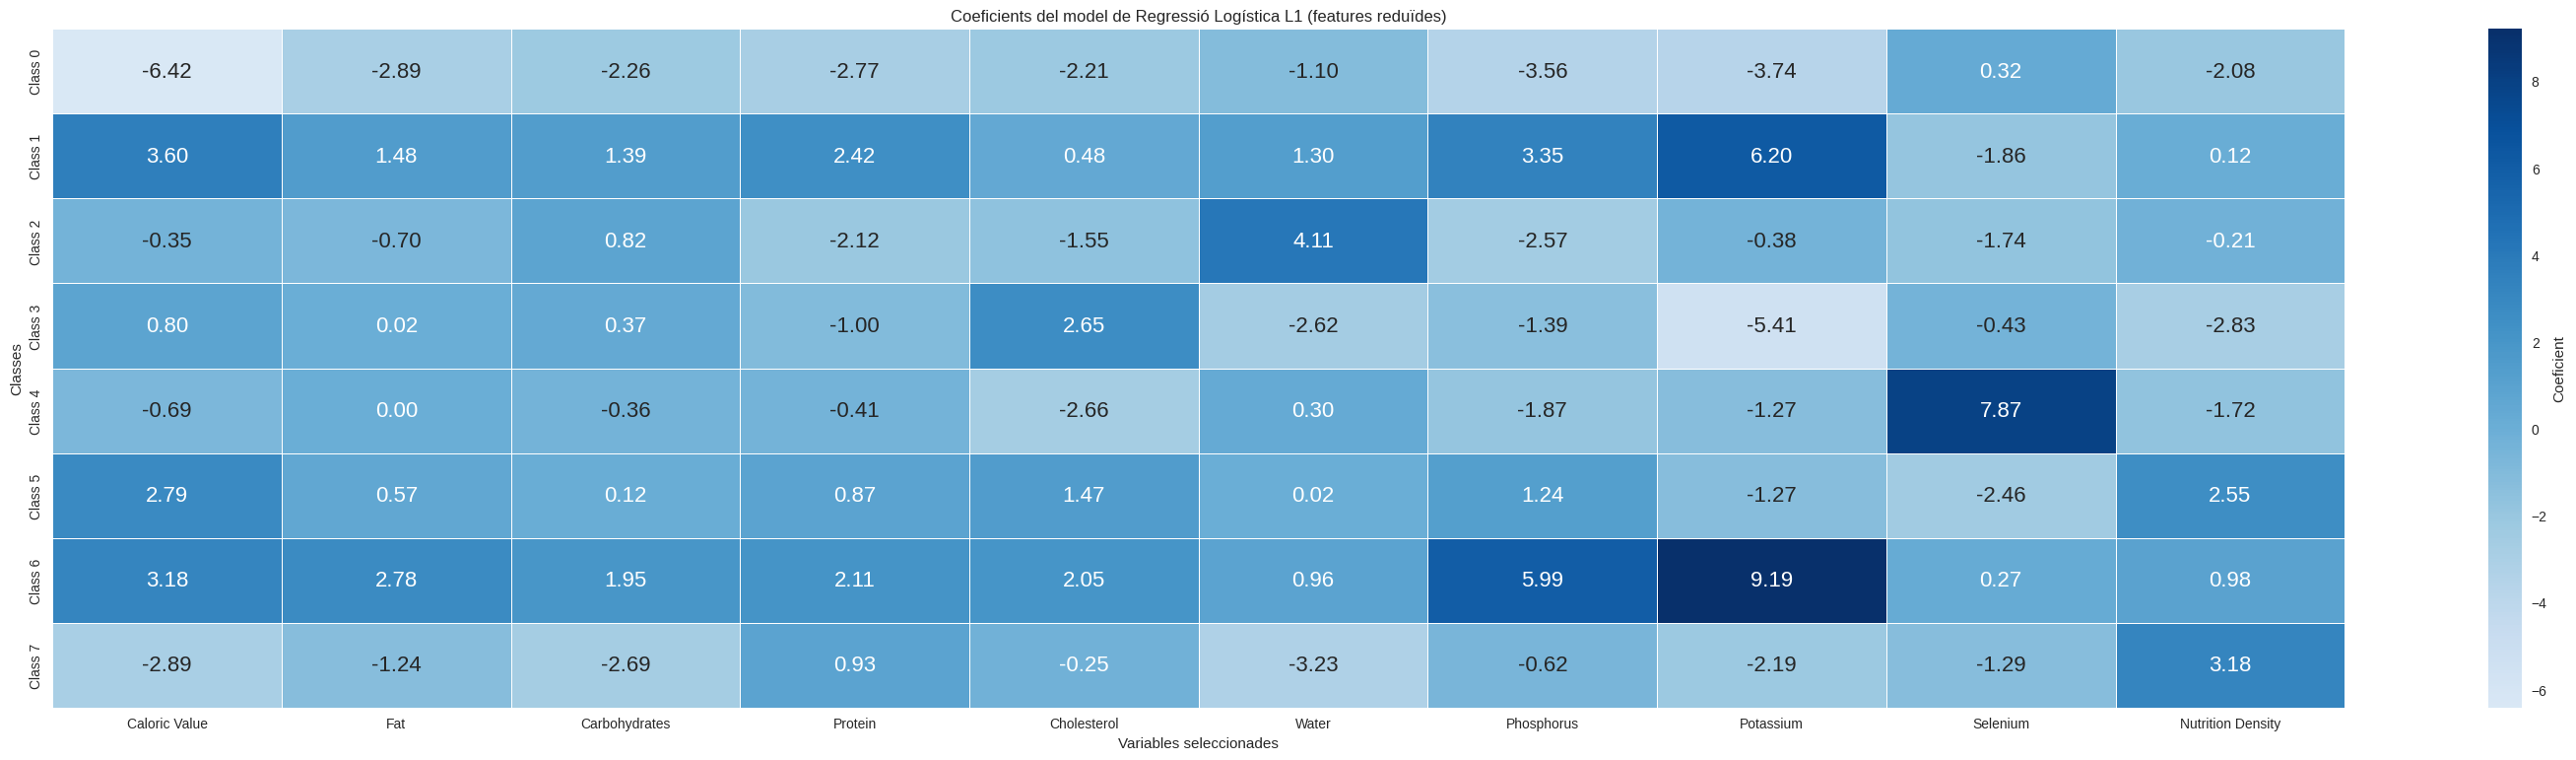

In [49]:
coefs_lr_reduced = pd.DataFrame(
    lr_model_reduced.coef_,
    columns=selected_features
)
coefs_lr_reduced.index = [f'Class {i}' for i in sorted(y_train.unique())]

print("Coeficients del model amb features reduïdes:")
display(coefs_lr_reduced)

# Visualització (heatmap) del nou model
plt.figure(figsize=(30,8))
sns.heatmap(coefs_lr_reduced, cmap='Blues', center=0, annot=True, fmt='.2f',
            cbar_kws={'label': 'Coeficient'}, linewidths=0.5)
plt.title('Coeficients del model de Regressió Logística L1 (features reduïdes)')
plt.xlabel('Variables seleccionades')
plt.ylabel('Classes')
plt.tight_layout()
plt.show();

In [50]:
for feat in selected_features:
    print(f"\nVariable: {feat}")
    print("  Pesos abans (model complet):")
    print(coefs_lr[feat])          # coefs_lr = coeficientes del modelo original
    print("  Pesos després (model reduït):")
    print(coefs_lr_reduced[feat])


Variable: Caloric Value
  Pesos abans (model complet):
Class 0   -2.602
Class 1    1.836
Class 2    0.000
Class 3    0.000
Class 4   -0.123
Class 5    0.634
Class 6    1.534
Class 7   -1.293
Name: Caloric Value, dtype: float64
  Pesos després (model reduït):
Class 0   -6.423
Class 1    3.600
Class 2   -0.346
Class 3    0.802
Class 4   -0.689
Class 5    2.790
Class 6    3.185
Class 7   -2.888
Name: Caloric Value, dtype: float64

Variable: Fat
  Pesos abans (model complet):
Class 0   -0.649
Class 1    0.759
Class 2   -0.055
Class 3    0.000
Class 4    0.000
Class 5    0.000
Class 6    0.641
Class 7    0.000
Name: Fat, dtype: float64
  Pesos després (model reduït):
Class 0   -2.887
Class 1    1.479
Class 2   -0.703
Class 3    0.019
Class 4    0.000
Class 5    0.566
Class 6    2.783
Class 7   -1.239
Name: Fat, dtype: float64

Variable: Carbohydrates
  Pesos abans (model complet):
Class 0   -1.477
Class 1    0.472
Class 2    0.328
Class 3    0.000
Class 4    0.000
Class 5    0.175
Class 6 

En el model de **Regressió Logística amb penalització L1**, aproximadament la meitat dels coeficients són exactament zeros, cosa que indica que la regularització ja està fent una primera selecció d’atributs i anul·lant moltes combinacions (classe, variable) que no aporten informació rellevant al model. Tot i això, L1 no decideix explícitament quin és el nombre òptim de variables a mantenir, sinó que simplement empeny molts pesos cap a zero.

Per aquest motiu hem aplicat **RFECV** (Recursive Feature Elimination with Cross-Validation) utilitzant com a estimador la regressió logística ajustada. Amb aquest mètode hem obtingut un subconjunt reduït de només **10 atributs**, amb un millor *score* de validació creuada de **0.8590**. A continuació, hem tornat a ajustar els hiperparàmetres de la regressió logística sobre aquest conjunt reduït de variables, obtenint com a millors valors `C = 5` i `max_iter = 1000`, amb una *accuracy* mitjana en validació creuada de **0.8705**, superior al **0.8379** obtingut pel model original amb totes les variables (`C = 0.5`).

Pel que fa al conjunt de test, el model amb totes les variables aconsegueix una *accuracy* de **0.85**, mentre que el model amb només 10 atributs puja fins a **0.88**. També milloren les mètriques *macro* i ponderades (per exemple, el macro f1 passa aproximadament de **0.84** a **0.87**), i en algunes classes s’observa una millora clara del compromís entre *precision* i *recall*, com en el cas de la **classe 7**, on el *recall* augmenta de `0.51` a `0.70`.

Això mostra que eliminar variables irrellevants o redundants redueix el sobreajust i permet obtenir un model més simple, més interpretable i amb millor capacitat de generalització, tot i utilitzar menys atributs.

Alhora veiem que els coeficients de les variables escollides abans quan s'usaven totes eren 0 per alguna classe pero ara cap coeficient és 0. Sembla que ara al tenir menys variables agafen més importància per definir les fronteres entre classes.


## Apartat e)
- Ajustar un model k-veïns próxims a les dades explorant adecuadament els seus paràmetres

- Avaluar la qualitat del model

- Comparar el model amb els altres

### KNN explorant els seus paràmetres

In [37]:
knn =  KNeighborsClassifier()
param = {'n_neighbors':list(range(1, 37, 2)), 'weights':['distance', 'uniform'], 'metric': ['l2', 'l1', 'cosine', 'euclidean', 'manhattan']}

knn_gs =  GridSearchCV(knn, param, cv = cv, n_jobs = -1)
knn_gs.fit(X_train_scaled, y_train);

In [38]:
show_html(pd.DataFrame(knn_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
38,"{'metric': 'l1', 'n_neighbors': 3, 'weights': 'distance'}",0.814,1
146,"{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}",0.814,1
37,"{'metric': 'l1', 'n_neighbors': 1, 'weights': 'uniform'}",0.811,3
36,"{'metric': 'l1', 'n_neighbors': 1, 'weights': 'distance'}",0.811,3
144,"{'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'distance'}",0.811,3


De tots els diferentes valors que s'han provat, els millors hiperparametres són:
 - **Metric**: l1 / manhattan       (en aquest cas agafarà l1, però les dues tenen la mateixa mean_test_score)
 - **n_neighbors**: 3
 - **weights**: distance
 - **Accuracy**: 0.814

### Avaluar la qualitat del model

In [39]:
print(classification_report(y_test, knn_gs.predict(X_test_scaled), target_names=[f'Class {i}' for i in sorted(y_train.unique())]))
results_df = save_results(knn_gs, X_test_scaled, y_test, 'KNN', results_df)

              precision    recall  f1-score   support

     Class 0       0.86      0.97      0.91        59
     Class 1       0.85      0.83      0.84        92
     Class 2       0.86      0.90      0.88        73
     Class 3       0.75      0.80      0.78        50
     Class 4       0.96      0.96      0.96        46
     Class 5       0.87      0.80      0.83        85
     Class 6       0.97      0.87      0.92        39
     Class 7       0.72      0.72      0.72        43

    accuracy                           0.85       487
   macro avg       0.86      0.86      0.85       487
weighted avg       0.86      0.85      0.85       487



El model `KNN` és bastant bo ja que té les tres mètriques (**precission**, **recall** i **f1-score**) amb un valor de 86%, 86% i 85%. Podem veure que la classes amb major rendiment amb diferència és la 4, que té les tres métriques amb un valor de 96%. Tal i com ens passava amb els models `GNB` i  `LDA`, les pitjors classes són tant la 3 com la 7, tot i que en aquest cas ens donen resultats prou bons.

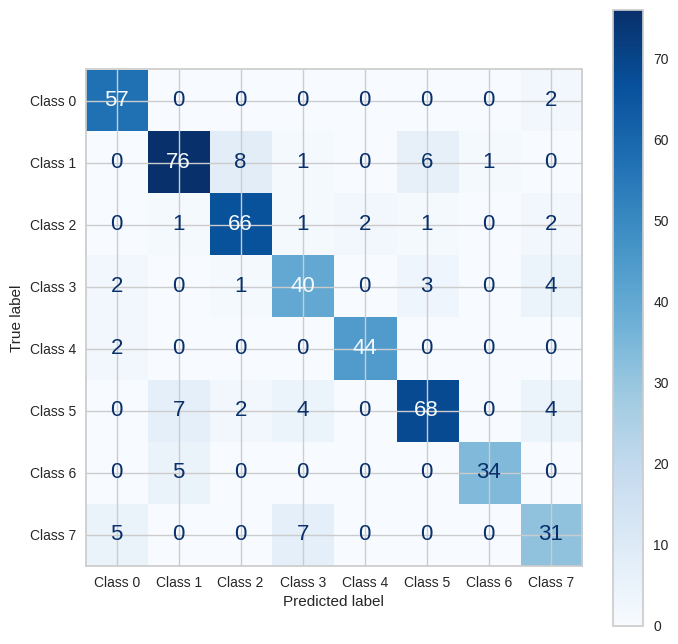

In [40]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(knn_gs, X_test_scaled, y_test, cmap="Blues", display_labels=[f'Class {i}' for i in sorted(y_train.unique())], ax=plt.subplot());

Amb la matriu de confussió podem veure millor el que representava el classification report. Destaquem que la classe 4, amb només 2 prediccions incorrectes sobre 46 exemples, té un molt bon rendiment.

### Comparar el model amb els altres

In [41]:
results_df_sorted = results_df.sort_values(by='test acc', ascending=False)
results_df_sorted

,train XV acc,test acc,precision score (M),recall score (M),f1 score (M)
LogReg L1 (RFECV),0.870,0.881,0.880,0.873,0.874
KNN,0.814,0.854,0.856,0.856,0.855
LogReg L1,0.838,0.854,0.867,0.836,0.841
GNB,0.758,0.741,0.742,0.740,0.723
LDA,0.631,0.657,0.707,0.630,0.624


Dels 5 models probats fins al moment, **KNN** és el segon millor classificador en quant a accuracy en el conjunt test (85.4%) empatat amb **Regressió Logística amb L1**. El **KNN** es comporta com un model sólid, però no és el millor ja que queda per darrere de **Regressió Logística amb L1 (RFECV)** en totes les métriques, tot i que rendeix bastant millor que **GNB** i **LDA**.
Tots els models s'ajusten bé, ja que l'accuraccy entre train i test son similars.  

## Apartat f)
 - Repetir cada model amb el conjunt reduit de variables (RFECV)
 - Comparar amb models anteriors
 - Quin model es millor?

### Naive Bayes

0.8140971898773481
Priors: [0.11982379 0.18854626 0.15066079 0.10220264 0.09515419 0.1753304
 0.08105727 0.08722467]
Means:

              precision    recall  f1-score   support

     Class 0       0.89      0.86      0.88        59
     Class 1       0.85      0.85      0.85        92
     Class 2       0.88      0.89      0.88        73
     Class 3       0.54      0.26      0.35        50
     Class 4       0.95      0.83      0.88        46
     Class 5       0.82      0.84      0.83        85
     Class 6       0.86      0.95      0.90        39
     Class 7       0.51      0.84      0.64        43

    accuracy                           0.80       487
   macro avg       0.79      0.79      0.78       487
weighted avg       0.80      0.80      0.79       487



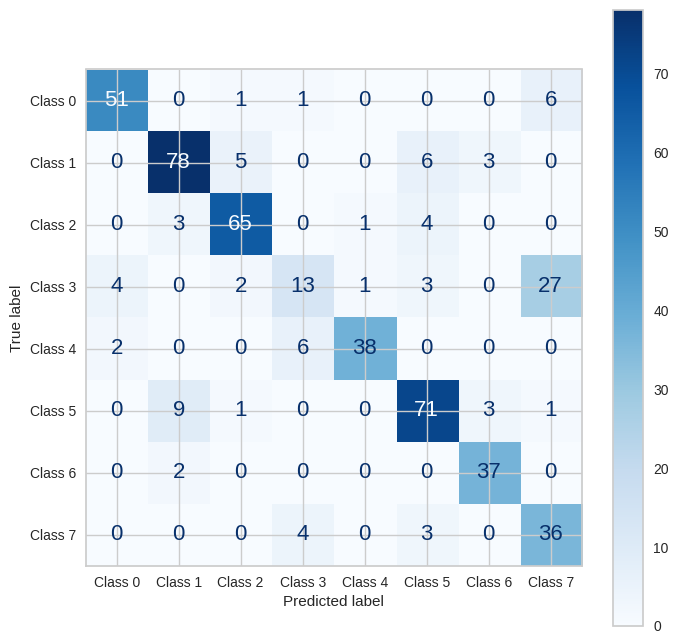

In [42]:
gnb = GaussianNB()
gnb.best_score_ = np.mean(cross_val_score(gnb,X_train_sel,y_train,cv=10))
print(gnb.best_score_)

gnb_model = GaussianNB().fit(X_train_sel, y_train)
gnb_model.best_score_ = gnb.best_score_
print('Priors:', gnb_model.class_prior_)
print('Means:\n')
means =pd.DataFrame(gnb_model.theta_)
means.columns=X_train_sel.columns
means

print(classification_report(y_test, gnb_model.predict(X_test_sel), target_names=[f'Class {i}' for i in sorted(y_train.unique())]))
results_df = save_results(gnb_model, X_test_sel, y_test, 'GNB Sel', results_df)

plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(gnb_model, X_test_sel, y_test, cmap="Blues",display_labels=[f'Class {i}' for i in sorted(y_train.unique())], ax=plt.subplot());

Veiem que igual que amb el **GNB** sense RFECV, les classes amb pitjor accuracy son la classe 3 i la 7, tot i que en general han millorat les métriques. Per tant, **GNB amb RFECV** és millor que **GNB**.

### Linear Discriminant Analysis

Accuracy de validació creuada LDA: 0.6219375873311599
Priors: [0.11982379 0.18854626 0.15066079 0.10220264 0.09515419 0.1753304
 0.08105727 0.08722467]

Mitjanes per classe:
              precision    recall  f1-score   support

     Class 0       0.38      1.00      0.55        59
     Class 1       0.82      0.82      0.82        92
     Class 2       0.81      0.92      0.86        73
     Class 3       0.72      0.36      0.48        50
     Class 4       1.00      0.67      0.81        46
     Class 5       0.63      0.54      0.58        85
     Class 6       1.00      0.72      0.84        39
     Class 7       0.00      0.00      0.00        43

    accuracy                           0.67       487
   macro avg       0.67      0.63      0.62       487
weighted avg       0.68      0.67      0.64       487



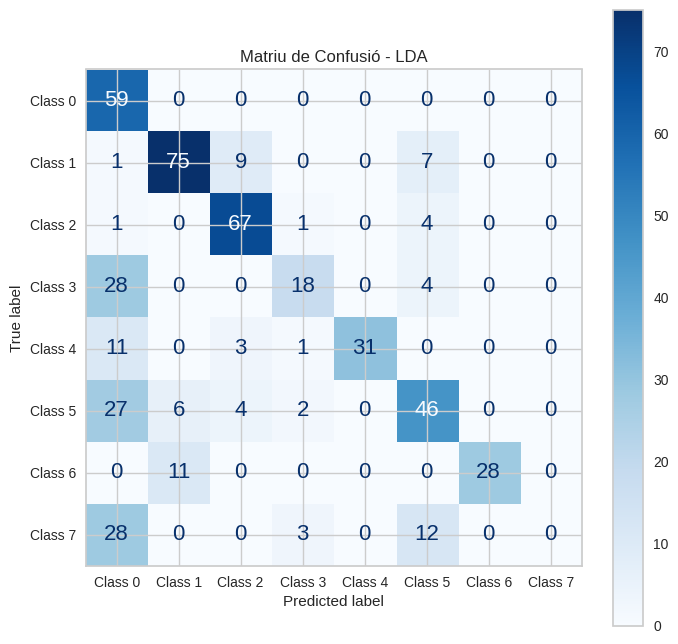

In [43]:
lda = LinearDiscriminantAnalysis()
lda.best_score_ = np.mean(cross_val_score(lda, X_train_sel, y_train, cv=10))
print('Accuracy de validació creuada LDA:', lda.best_score_)

lda_model = LinearDiscriminantAnalysis().fit(X_train_sel, y_train)
lda_model.best_score_ = lda.best_score_

print('Priors:', lda_model.priors_)
print('\nMitjanes per classe:')
means_lda = pd.DataFrame(lda_model.means_, columns=X_train_sel.columns)
means_lda.index = [f'Class {i}' for i in sorted(y_train.unique())]
means_lda
print(classification_report(y_test, lda_model.predict(X_test_sel), target_names=[f'Class {i}' for i in sorted(y_train.unique())]))
results_df = save_results(lda_model, X_test_sel, y_test, 'LDA Sel', results_df)
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(lda_model, X_test_sel, y_test, cmap="Blues", display_labels=[f'Class {i}' for i in sorted(y_train.unique())], ax=plt.subplot())
plt.title('Matriu de Confusió - LDA')
plt.show();

Veiem que igual que amb el **LDA** sense RFECV, les classes amb pitjor accuracy son la classe 0 i la 7. La precissió de la classe 3 ha millorat, però les mètriques de la classe 7 han empitjorat moltíssim (ara valen 0). Podem veure a la confusion matrix que no es detecta cap element de la classe 7, i que continua havent-hi molta confusió de classes en general. Malgrat això, **LDA amb RFECV** és millor que **LDA**.

### K-Nearest Neighbours

,params,mean_test_score,rank_test_score
14,"{'metric': 'l1', 'n_neighbors': 3, 'weights': 'distance'}",0.900,1
50,"{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}",0.900,1
38,"{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}",0.899,3
2,"{'metric': 'l2', 'n_neighbors': 3, 'weights': 'distance'}",0.899,3
36,"{'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}",0.898,5


              precision    recall  f1-score   support

     Class 0       0.89      0.98      0.94        59
     Class 1       0.91      0.87      0.89        92
     Class 2       0.93      0.97      0.95        73
     Class 3       0.90      0.92      0.91        50
     Class 4       0.98      0.96      0.97        46
     Class 5       0.92      0.92      0.92        85
     Class 6       0.97      0.95      0.96        39
     Class 7       0.95      0.86      0.90        43

    accuracy                           0.93       487
   macro avg       0.93      0.93      0.93       487
weighted avg       0.93      0.93      0.93       487



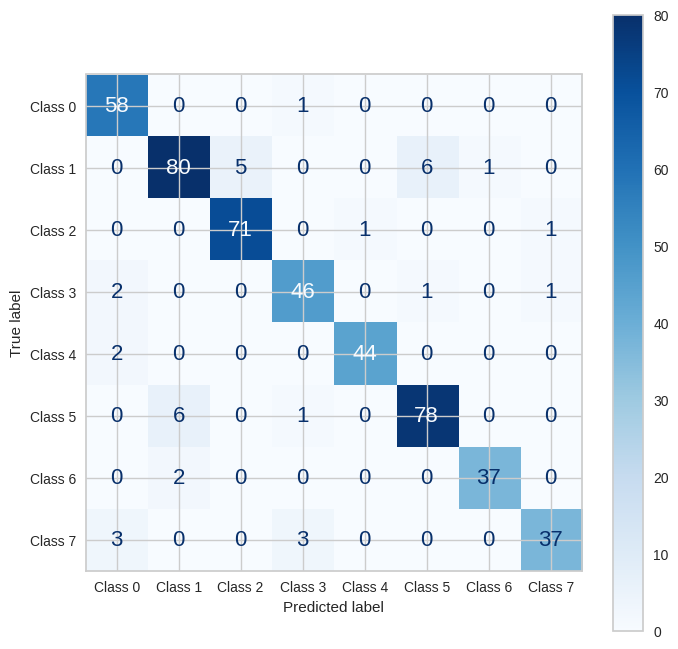

In [44]:
knn =  KNeighborsClassifier()
param = {'n_neighbors':[1, 3, 5, 7, 11, 15], 'weights':['distance', 'uniform'], 'metric': ['l2', 'l1', 'cosine', 'euclidean', 'manhattan']}

knn_gs =  GridSearchCV(knn,param,cv=cv, n_jobs=-1)
knn_gs.fit(X_train_sel, y_train);

show_html(pd.DataFrame(knn_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

print(classification_report(y_test, knn_gs.predict(X_test_sel), target_names=[f'Class {i}' for i in sorted(y_train.unique())]))
results_df = save_results(knn_gs, X_test_sel, y_test, 'KNN Sel', results_df)

plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(knn_gs, X_test_sel, y_test, cmap="Blues", display_labels=[f'Class {i}' for i in sorted(y_train.unique())], ax=plt.subplot());

A diferència que amb el **KNN** sense RFECV, les classes amb pitjor accuracy ja no son la classe 3 i la 7. En aquest cas, al aplicar RFECV veiem que totes les métriques son molt altes: totes per sobre del 85% i amb precisions de més de 90%. Mirant a la confusion matrix veiem els mateixos resultats: la grandíssima majoria d'elements es prediuen correctament. Per tant, **KNN amb RFECV** és millor que **KNN**.

### Comparar models

In [45]:
results_df_sorted = results_df.sort_values(by='test acc', ascending=False)
results_df_sorted

,train XV acc,test acc,precision score (M),recall score (M),f1 score (M)
KNN Sel,0.900,0.926,0.932,0.929,0.930
LogReg L1 (RFECV),0.870,0.881,0.880,0.873,0.874
KNN,0.814,0.854,0.856,0.856,0.855
LogReg L1,0.838,0.854,0.867,0.836,0.841
GNB Sel,0.814,0.799,0.788,0.789,0.776
GNB,0.758,0.741,0.742,0.740,0.723
LDA Sel,0.622,0.665,0.669,0.628,0.616
LDA,0.631,0.657,0.707,0.630,0.624


Veient els resultats de la taula, veiem el mateix que hem vist anteriorment en aquest apartat: els tres models (**GNB**, **LDA** i **KNN**) milloren al aplicar RFECV. Veiem que el model que menys millora és el **LDA**, principalment degut a que la precisió de la classe 7 empitjora moltíssim (no es detecta cap element de la classe 7, com hem vist abans) mentres que el model que més millora (un 9%) és el **KNN**.

### Quin model és millor?
Al llarg d'aquest exercici, hem anat comentat ja com funciona i el rendiment de cada model. Jutjant pels resultats de cada un, veiem clarament que el millor model és el KNN amb les varibles reduides. Ja que com hem dit al apart d, reduir el nombre de variables reduiex el sobreajust i millora la generalització.